#### Import the needed libraries

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
from scipy.interpolate import UnivariateSpline as spline
from sklearn.model_selection import ParameterGrid
from sklearn import metrics
from termcolor import colored
import matplotlib.pyplot as plt
import numpy as np
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import Title, LabelSet, Label, ColumnDataSource
from bokeh.layouts import row
output_notebook()

Loading BokehJS ...

#### Load data and Preprocessing

In [2]:
def data_preprocessing(input_name: str, output_name: str):
    print(colored("LOADED FILE " + input_name[5:7] + " !!!", 'blue'))
    _data = pd.read_csv(input_name, sep="\t")
    _data.index = range(_data.shape[0])
    _data.columns = ["y"]
    _data["x"] = range(_data.shape[0])

    # position of the missing prices
    _pos_missing = _data.y.str.startswith("Missing")

    DATA_MISSING = _data[_pos_missing]

    # training data set
    DATA_TRAINING = _data[_pos_missing == False]

    ACTUAL_PRICES = pd.read_csv(output_name, header=None)
    return DATA_TRAINING, DATA_MISSING, ACTUAL_PRICES

#### Build a grid search fuction

In [3]:
def grid_search(data_training, model, param_grid):
    """
    :param data_training:
    :param model: the function that defines the model.
    :param param_grid: Sklearn ParameterGrid
    :return: sorted Pandas DataFrame of the gridsearch and the corresponding MSE.
    """

    x_train, x_val, y_train, y_val = train_test_split(
        data_training.x, data_training.y, test_size=0.1, random_state=42
    )

    # sort the data because the x value of spline must be increasing.
    train_data = pd.DataFrame({"x": x_train, "y": y_train}).sort_values("x")
    val_data = pd.DataFrame({"x": x_val, "y": y_val}).sort_values("x")

    param_grid_result = pd.DataFrame.from_dict(list(param_grid))
    val_MSE = []
    tr_MES = []

    for ind, grid in enumerate(param_grid):
        trained_model = model(train_data, **grid)
        y_predicted = trained_model(val_data.x)
        val_error = metrics.mean_squared_error(y_predicted, val_data.y)
        val_MSE.append(round(val_error, 6))
        
        training_pred = trained_model(train_data.x)
        tr_error = metrics.mean_squared_error(training_pred, train_data.y)
        tr_MES.append(round(tr_error, 6))
        
    
    param_grid_result["Train_MSE"] = tr_MES
    param_grid_result["Validation_MSE"] = val_MSE
    return param_grid_result

#### Build The Model

In [4]:
def spline_interpolation(train, **kwargs):
    """
    :param train: Pandas DataFrame - Stock prices with some missing values. dim = (n, 2)
    :param kwargs: dict with keys degree_spline and smoothing_factor
                1. degree_spline: int - Degree of the smoothing spline. Must be <= 5. 
                Default is k=3, a cubic spline.
                2. smoothing_factor: float - Smoothing factor used to choose the 
                no. of knots. No. of knots will be increased until the smoothing 
                condition is satisfied.
    :return: A function that holds the trained model.
    """

    spline_model = spline(
        train.x, train.y, k=kwargs["degree_spline"], s=kwargs["smoothing_factor"]
    )

    return spline_model

In [5]:
def heatmap(metric, x_axis, y_axis, title):
    """
    :param metric: the computed value - e.g MSE, RMSE
    :param x_axis: values on the x-axis
    :param y_axis: values on the y-axis
    :param title: Plot title
    :return: None - Renders the plot.
    """
    plt.figure(figsize=(4, 4))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(
        np.reshape(list(metric), (4, 4)),
        interpolation="nearest",
        cmap=plt.cm.hot
    )
    plt.xlabel("Degree of Spline")
    plt.ylabel("Smoothing Factor")
    plt.colorbar()
    plt.xticks(np.arange(4), x_axis, rotation=45)
    plt.yticks(np.arange(4), y_axis)
    plt.title(title)
    plt.show()

# <u> Working With Dataset

#### Specify the data to be loaded
- Change the input data to work through other a specific file.

In [6]:
input_file = "input00.txt"
output_file = "output00.txt"

In [7]:
DATA_TRAINING, DATA_MISSING, ACTUAL_PRICES = data_preprocessing(input_file, output_file)

LOADED FILE 00 !!!


#### Find optimal Parameters via grid search

In [8]:
degree_spline = [2, 3, 4, 5]
smoothing_factor = [2, 3, 4, 5]

param_grid = ParameterGrid(
    dict(degree_spline=degree_spline, smoothing_factor=smoothing_factor)
)

grid_search_result = grid_search(
    DATA_TRAINING, model=spline_interpolation, param_grid=param_grid
)

grid_search_result.sort_values(['Train_MSE', 'Validation_MSE']).head()

,degree_spline,smoothing_factor,Train_MSE,Validation_MSE
0,2,2,0.009659,0.132434
12,5,2,0.009660,0.134916
8,4,2,0.009661,0.121957
4,3,2,0.009663,0.118139
5,3,3,0.014486,0.100552


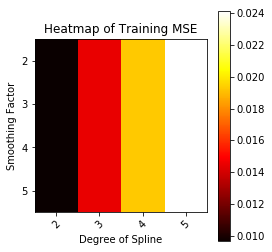

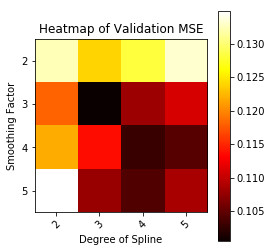

In [9]:
heatmap(
    grid_search_result.Train_MSE,
    degree_spline,
    smoothing_factor,
    "Heatmap of Training MSE",
)
heatmap(
    grid_search_result.Validation_MSE,
    degree_spline,
    smoothing_factor,
    "Heatmap of Validation MSE",
)

#### Predict the missing stock prices
- while choosing the set of parameters needed for bias-variance tradeoff.
- degree_spline=3 and smoothing_factor=3 will be used because it performs better across the 3 input files.

In [10]:
pred_missing_prices = spline_interpolation(
    DATA_TRAINING,
    degree_spline=3,
    smoothing_factor=3
)(DATA_MISSING.x)

In [11]:
pd.DataFrame(
    {
        "predicted missing prices": pred_missing_prices,
        "Actual": ACTUAL_PRICES.iloc[:, 0].tolist(),
    },
    index=DATA_MISSING.x.tolist()
).head()

,predicted missing prices,Actual
48,32.668939,32.69
54,32.025778,32.15
57,32.521154,32.61
99,29.395604,29.30
104,28.924277,28.96


The Mean Square Error:

In [12]:
round(metrics.mean_squared_error(pred_missing_prices, ACTUAL_PRICES), 6)

0.06727

# Visualization
- Using an interactive plot

#### Combine actual data with the predicted prices

In [13]:
x_y_predictd = DATA_MISSING.copy()
x_y_predictd.y = pred_missing_prices
all_with_pred = pd.concat([DATA_TRAINING, x_y_predictd])
all_with_pred = all_with_pred.sort_values('x')

#### Combine actual data

In [14]:
all_x_y_actual = DATA_MISSING.copy()
all_x_y_actual.y = ACTUAL_PRICES.iloc[:, 0].tolist()
all_with_actual = pd.concat([DATA_TRAINING, all_x_y_actual])

In [15]:
fig = figure(
    title="Viewing the closeness of Actual vs. Predicting values of the Missing Stock Prices",
    width=950,
    height=700,
)

fig.title.text_font_size = "20px"
source = ColumnDataSource(
    data=dict(x=all_x_y_actual.x, y=all_x_y_actual.y, pointer=range(1, 21))
)
fig.scatter(x="x", y="y", color="navy", legend=["Actual"], source=source)
fig.scatter(x_y_predictd.x, x_y_predictd.y, color="firebrick", legend=["Predicted"])
fig.xaxis[0].axis_label = "Ordered Period (x)"
fig.yaxis[0].axis_label = "Stock Prices (y)"
labels = LabelSet(
    x="x",
    y="y",
    text="pointer",
    level="glyph",
    x_offset=5,
    y_offset=5,
    source=source,
    render_mode="canvas",
)

fig.add_layout(labels)
show(fig)

In [16]:
fig_act = figure(
    plot_width=475,
    plot_height=300,
    title="All data with the actual values of the missing prices",
)
fig_act.scatter(all_with_actual.x, all_with_actual.y, color="navy")
fig_act.xaxis[0].axis_label = "Ordered Period (x)"
fig_act.yaxis[0].axis_label = "Stock Prices (y)"

fig_pred = figure(
    plot_width=475,
    plot_height=300,
    title="All data with the estimated values of the missing prices",
)
fig_pred.scatter(all_with_pred.x, all_with_pred.y, color="firebrick")
fig_pred.xaxis[0].axis_label = "Ordered Period (x)"
fig_pred.yaxis[0].axis_label = "Stock Prices (y)"

show(row(fig_act, fig_pred))

In [17]:
fig = figure(
    title="Positioning the side-by-side plots above in a single view", width=900
)
fig.scatter(all_with_pred.x, all_with_pred.y, color="firebrick", legend=["Predicted"])
fig.scatter(all_with_actual.x, all_with_actual.y, color="navy", legend=["Actual"])
fig.xaxis[0].axis_label = "Ordered Period (x)"
fig.yaxis[0].axis_label = "Stock Prices (y)"
show(fig)
